<a href="https://colab.research.google.com/github/fatday/My-Grad-Math-Works/blob/main/AppliedStatistics/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW3: Hidden Markov Models

STATS305B, Stanford University, Winter 2025

**Your name:** Justin Li

**Collaborators:** TBD

**Hours spent:** TBD

-----

This assignment will focus on latent variable models for spatiotemporal data. Here, our focus is on climate data, analyzing long-term trends in global temperature.

* **Data**: Mean temperature in the lower troposphere from [NOAA](https://www.ncei.noaa.gov/products/climate-data-records/mean-layer-temperature-noaa). The data is sampled monthly from 1981 to 2024, and it has global coverage on a 2.5° $\times$ 2.5° grid.
* **Model**: We will use **Hidden Markov Models (HMMs)** to look for anomalies in global temperature trends.
* **Algorithm**: We'll fit the model using **Expectation-Maximization (EM)** and the **forward-backward algorithm**.

## Setup

In [1]:
%%capture
%pip install jaxtyping
%pip install basemap

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from datetime import datetime
from mpl_toolkits.basemap import Basemap
from jaxtyping import Float, Bool
from torch import Tensor
from torch.distributions import Normal
from tqdm.auto import trange
from typing import Optional, Tuple

### Load the data

This dataset was downloaded from [NOAA](https://www.ncei.noaa.gov/products/climate-data-records/mean-layer-temperature-noaa). It consists of the following fields:
- `temperature`: a Tensor of shape $T \times D_{\mathsf{lat}} \times D_{\mathsf{lon}}$ where
    - $T$ denotes the number of timesteps,
    - $D_{\mathsf{lat}}$ specifies the number of latitudes grid points, and
    - $D_{\mathsf{lon}}$ specifies the number of longitude grid points.

  Note that the temperature is measured in [degrees Kelvin](https://en.wikipedia.org/wiki/Kelvin) and it represents the average temperature in the [lower troposphere](https://www.noaa.gov/jetstream/atmosphere/layers-of-atmosphere), which extends up to 6-20km from the Earth's surface. The reported temperature is the mean temperature for the corresponding month.

- `latitude`: Tensor of shape $(D_{\mathsf{lat}}+1) \times (D_{\mathsf{lon}}+1)$ with a latitude for the edges of each bin in the grid
- `longitude`: Tensor of shape $(D_{\mathsf{lat}}+1) \times (D_{\mathsf{lon}}+1)$ with a longitude for the edges of each bin in the grid
- `dates`: Numpy array of shape $T$ and dtype `datetime64` containing the date of each measurement.

We performed some light preprocessing to make the data easier to work with. Specifically, we:
- Extracted the data from the original netCDF4 format and converted it into PyTorch tensors.
- Dropped missing data for the poles ($|\mathrm{latitude}| >82.5$).
- Created a meshgrid of latitude and longitude for plotting.
- Created a numpy array of dates for the time series.


In [3]:
# Download the data
!wget -nc https://github.com/slinderman/stats305b/raw/refs/heads/winter2025/assignments/hw3/hw3.pt

--2025-02-19 08:42:00--  https://github.com/slinderman/stats305b/raw/refs/heads/winter2025/assignments/hw3/hw3.pt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/slinderman/stats305b/refs/heads/winter2025/assignments/hw3/hw3.pt [following]
--2025-02-19 08:42:00--  https://media.githubusercontent.com/media/slinderman/stats305b/refs/heads/winter2025/assignments/hw3/hw3.pt
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20156536 (19M) [application/octet-stream]
Saving to: ‘hw3.pt’

hw3.pt              100%[===================>]  19.22M  73.5MB/s    in 0.3s    

2025-02-19 08:42:01 (

In [4]:
hw3_dataset = torch.load('hw3.pt', weights_only=False)
temperature = hw3_dataset['temperature']
latitude = hw3_dataset['latitude']
longitude = hw3_dataset['longitude']
dates = hw3_dataset['dates']

### Helper function for plotting

In [6]:
def plot_temperature(data : Float[Tensor, "n_latitude n_longitude"],
                     lats : Float[Tensor, "n_latitude n_longitude"],
                     lons : Float[Tensor, "n_latitude n_longitude"],
                     title : Optional[str]=None,
                     cmap : Optional[np.array]=sns.color_palette("icefire", as_cmap=True),
                     ax: Optional[plt.Axes]=None,
                     **kwargs) -> None:
    """
    Plot the temperature data using Basemap.

    Parameters
    ----------
    data : Float[Tensor, "n_latitude n_longitude"]
        The temperature data to plot.

    lats : Float[Tensor, "n_latitude n_longitude"]
        A meshgrid of latitudes

    lons : Float[Tensor, "n_latitude n_longitude"]
        A meshgrid of longitudes

    title : Optional[str]
        The title of the plot

    cmap : Optional[np.Array]
        The colormap to use for the plot

    ax : Optional[plt.Axes]
        The axes to plot on

    **kwargs:
        Additional arguments to pass to the Basemap `pcolormesh` function.
        For example, you may want to set the `vmin` and `vmax` values for the colormap.
    """
    # create figure, axes instances.
    if ax is None:
        fig = plt.figure()
        ax = fig.add_axes([0.05,0.05,0.9,0.9])

    # create Basemap instance.
    m = Basemap(projection='mill',
                llcrnrlon=-180,
                llcrnrlat=-82.5,
                urcrnrlon=180,
                urcrnrlat=82.5,
                ax=ax)

    # draw boundarie and coasts
    m.drawmapboundary(fill_color='0.8')
    m.drawcoastlines(linewidth=1)

    # plot temperature as a colormap
    im = m.pcolormesh(np.array(lons),
                      np.array(lats),
                      data,
                      shading='flat',
                      cmap=cmap,
                      latlon=True,
                      **kwargs)

    # draw parallels and meridians, but don't bother labelling them.
    m.drawparallels(np.arange(-90.,90.,30.))
    m.drawmeridians(np.arange(-180.,180.,60.))
    m.colorbar(im,"bottom", size="5%", pad="2%", label="°K")
    ax.set_title(title)

You can use this function to visualize the global temperature as a heatmap.


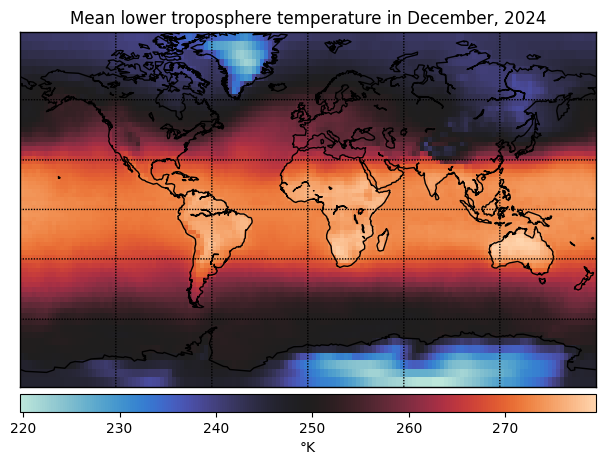

In [7]:
t = -1
date_to_str = lambda date: date.astype(datetime).strftime('%B, %Y')
plot_temperature(temperature[t], latitude, longitude,
                 title=f"Mean lower troposphere temperature in {date_to_str(dates[t])}")

### Extract global mean temperature over time

For the first part of this assignment, we will ignore the spatial component of the data and focus on the time series of global mean temperatures.

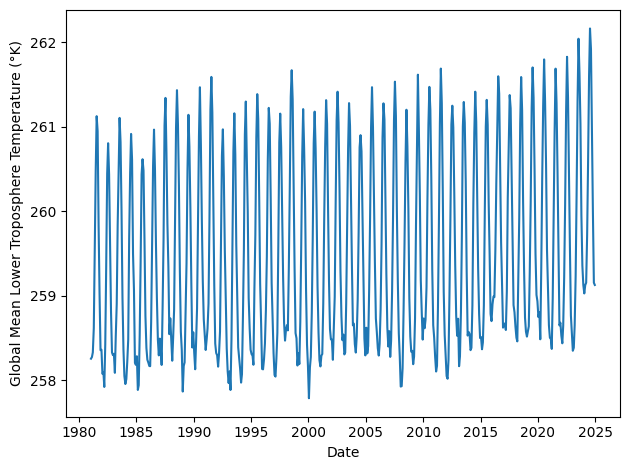

In [8]:
global_temps = temperature.mean(axis=(1,2))

plt.plot(dates, global_temps)
plt.xlabel('Date')
plt.ylabel('Global Mean Lower Troposphere Temperature (°K)')
plt.tight_layout()

You can see the trend by eye: Over the past 45 years, the global mean temperature in the lower troposphere has been rising by about 0.14 °K each decade. (The Kelvin scale is a shifted version of the Celcius scale, so this is equivalent to 0.14 °C/decade.)

In this assignment, we will model these trends and look for anomalies using hidden Markov models (HMM).

## Part 0: Establishing a Baseline

Our first step is to establish a baseline using linear regression. Let,
- $T=528$ denote the number of months of measurements in the dataset.
- $y_t \in \mathbb{R}$ denote the global mean temperature in month $t=1,\ldots,T$.
- $d_t \in \{1,\ldots,12\}$ denote which month the measurement was made in.

### Problem 0a: Fit a linear model

Compute $\hat{\boldsymbol{\beta}}_{\mathsf{MLE}}$, the maximum likelihood estimate of the weights for a linear regression model,
\begin{align*}
y_t &= \boldsymbol{\beta}^\top \mathbf{x}_t + \epsilon_t
\end{align*}
where are assumed to be $\epsilon_t$ are independent, mean zero noise terms.

Use the following covariates,
\begin{align*}
\mathbf{x}_t = (t, \mathbb{I}[d_t = 1], \ldots, \mathbb{I}[d_t=12]) \in \mathbb{R}^{13}.
\end{align*}

In [9]:
# We'll help you extract the months as integers
months = torch.tensor([date.astype(datetime).month for date in dates])

# YOUR CODE HERE
global_mean_temp = temperature.mean(axis=(1,2)) # y_t
x_t = torch.zeros(global_mean_temp.shape[0], 13) # x_t
for t in range(1, global_mean_temp.shape[0] + 1):
  x_t[t - 1][0] = t
  x_t[t - 1][months[t - 1]] = 1

# fit linear model get beta_mle
beta_mle = torch.linalg.inv(x_t.T @ x_t) @ x_t.T @ global_mean_temp

In [10]:
cnt = 0
val = 0
for t in range(global_mean_temp.shape[0]):
  if t % 12 == 1:
    cnt += 1
    val += global_mean_temp[t]
print(global_mean_temp[1], val/cnt + 2 * beta_mle[0])

tensor(258.2765) tensor(258.3147)


In [11]:
beta_mle[1]

tensor(258.0480)

In [12]:
beta_mle

tensor([1.2457e-03, 2.5805e+02, 2.5799e+02, 2.5806e+02, 2.5859e+02, 2.5951e+02,
        2.6055e+02, 2.6103e+02, 2.6066e+02, 2.5980e+02, 2.5892e+02, 2.5831e+02,
        2.5814e+02])

### Problem 0b: Plot the predictions and residuals

Plot the measurements $y$ predictions and $\hat{y}_t = \hat{\boldsymbol{\beta}}_{\mathsf{MLE}}^\top \mathbf{x}_t$.]

In a separate panel, plot the residuals $r_t \triangleq y_t - \hat{y}_t$.

Remember to label your axes!

In [13]:
# YOUR CODE HERE
y_hat_baseline = x_t @ beta_mle
r_t_baselibe = global_mean_temp - y_hat_baseline

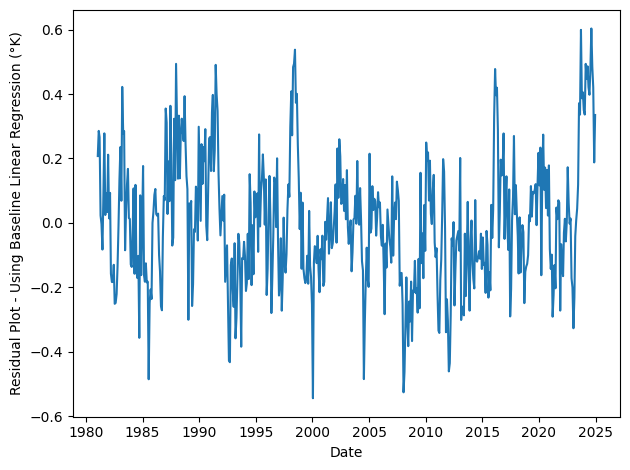

In [14]:
# plot residual
plt.plot(dates, r_t_baselibe)
plt.xlabel('Date')
plt.ylabel('Residual Plot - Using Baseline Linear Regression (°K)')
plt.tight_layout()

### Problem 0c: Discuss

How do you interpret the estimated coefficients of this model?


The intercept in the $\hat{\mathbf{\beta}}_{MLE}$ shows the relationship between global temperature and time, so it indicates that how global temperature changes each month as time goes by, we can consider this as the linear trend effect in time series.

The coefficients of $\mathbb{I}\{d_t=i\}$ in $\hat{\mathbf{\beta}}_{MLE}$ shows month $i$'s average effect on global temperature at start point (consider as the effect at $t=0$), we can consider this as the seasonal effect in time series.

## Part 1: State Inference with the Forward-Backward Algorithm

You should see that the residuals look autocorrelated: if $r_t$ is positive, $r_{t+1}$ is likely to be positive as well. There are several factors that could lead to such autocorrelation; one is the [El Niño Southern Oscillation (ENSO)](https://en.wikipedia.org/wiki/El_Ni%C3%B1o%E2%80%93Southern_Oscillation). These global variations lead to periods of warming (El Niño) and cooling (La Niña) that last around a year and occur every 2-7 years (according to Wikipedia). We will attempt to infer these events using a Hidden Markov Model (HMM).

Let $z_t \in \{1,\ldots,K\}$ denote a **discrete latent state** at time $t$. We will model the residuals as _conditionally independent_ given the latent states,
\begin{align*}
r_t \mid z_t = k &\sim \mathrm{N}(\mu_k, \sigma_k^2),
\end{align*}
where $(\mu_k, \sigma_k^2)$ denote the mean and variance of the residuals in state $k$.

We model the latent states as a Markov process,
\begin{align*}
\Pr(z_{t+1}=j \mid z_t =i) = p_{ij},
\end{align*}
where $p_{ij}$ are the elements of the transition matrix,
\begin{align*}
\mathbf{P} =
\begin{bmatrix}
p_{11} & \ldots & p_{1K} \\
\vdots & & \vdots \\
p_{K1} & \ldots & p_{KK}
\end{bmatrix}
\end{align*}

Finally, we assume
\begin{align*}
z_1 \sim \mathrm{Cat}(\boldsymbol{\pi}_0)
\end{align*}
where $\boldsymbol{\pi}_0$ is the initial distribution.

The parameters of the model are $\theta = (\{\mu_k, \sigma_k^2\}_{k=1}^K, \mathbf{P}, \boldsymbol{\pi}_0)$. Our goal is to estimate the parameters and infer the posterior marginal distributions of the latent states.


### Problem 1a: Forward-Backward Algorithm

Implement the forward-backward algorithm for computing posterior marginal probabilities,
\begin{align*}
\Pr(z_t = k \mid r_{1:T}; \theta) = \mathbb{E}[\mathbb{I}[z_t=k] \mid r_{1:T}; \theta].
\end{align*}
Also, compute the log marginal likelihood, $\log p(r_{1:T}; \theta)$, during the forward pass.

In [245]:
def forward_pass(initial_probs: Float[Tensor, "num_states"],
                 transition_matrix: Float[Tensor, "num_states num_states"],
                 log_likes: Float[Tensor, "num_timesteps num_states"]) \
                 -> Tuple[Float[Tensor, "num_timesteps num_states"], Float]:
    r"""
    Compute the filtering probabilities, $p(z_t | r_{1:t-1})$ and the marginal
    log likelihood, $\log p(r_{1:T})$, where $z_t$ is the hidden state at time $t$
    and $r_{1:t-1}$ is the observed data up to time $t-1$.

    Parameters
    ----------
    initial_probs : Float[Tensor, "num_states"]
        The initial state probabilities, $p(z_1)$.

    transition_matrix : Float[Tensor, "num_states num_states"]
        The state transition probabilities, $p(z_t | z_{t-1})$.

    log_likes : Float[Tensor, "num_timesteps num_states"]
        The log likelihoods, $\log p(r_t | z_t)$.

    Returns
    -------
    alphas : Float[Tensor, "num_timesteps num_states"]
        The filtering probabilities, $p(z_t | r_{1:t-1})$.

    marginal_loglike : Float
        The marginal log likelihood, $\log p(r_{1:T})$.

    """
    # YOUR CODE HERE

    num_timesteps, num_states = log_likes.shape

    # Initialize alpha matrix and memo marginal
    alphas = torch.zeros((num_timesteps, num_states), dtype=torch.float32)
    marginal_cur = torch.zeros((num_timesteps, num_states), dtype=torch.float32)

    # base
    alphas[0] = initial_probs
    marginal_cur[0] = torch.log(initial_probs) + log_likes[0]

    for t in range(1, num_timesteps):

        alphas[t] = transition_matrix.T @ (alphas[t - 1] * torch.exp(log_likes[t - 1]))
        alphas[t] /= torch.sum(alphas[t])
        marginal_cur[t] = torch.logsumexp(marginal_cur[t-1].unsqueeze(1) + torch.log(transition_matrix), dim=0) + log_likes[t]

    marginal_loglike = torch.logsumexp(marginal_cur[-1], dim=0)

    return alphas, marginal_loglike


def backward_pass(transition_matrix: Float[Tensor, "num_states num_states"],
                  log_likes: Float[Tensor, "num_timesteps num_states"]) \
                  -> Float[Tensor, "num_timesteps num_states"]:
    r"""
    Compute the backward probabilities, $\beta_t \propto p(z_t, r_{t+1:T})$

    Parameters
    ----------
    transition_matrix : Float[Tensor, "num_states num_states"]
        The state transition probabilities, $p(z_t | z_{t-1})$.

    log_likes : Float[Tensor, "num_timesteps num_states"]
        The log likelihoods, $\log p(r_t | z_t)$.

    Returns
    -------
    betas : Float[Tensor, "num_timesteps num_states"]
        The backward probabilities, $\beta_t \propto p(z_t, r_{t+1:T})$.

    """
    # YOUR CODE HERE
    num_timesteps, num_states = log_likes.shape
    betas = torch.zeros(num_timesteps, num_states)
    betas[num_timesteps - 1] = torch.ones(num_states)
    for t in range(num_timesteps - 2, -1, -1):
        betas[t] = transition_matrix @ (betas[t + 1] * torch.exp(log_likes[t + 1]))
    return betas


def forward_backward(initial_probs: Float[Tensor, "num_states"],
                     transition_matrix: Float[Tensor, "num_states num_states"],
                     log_likes: Float[Tensor, "num_timesteps num_states"]) \
                     -> Tuple[Float[Tensor, "num_timesteps num_states"], Float]:
    r""" Run the forward backward algorithm to compute the posterior expected states,
    $Pr(z_t=k | r_{1:T})$ for all $t$ and $k$, and the marginal log likelihood,
    $\log p(r_{1:T})$.

    Parameters
    ----------
    initial_probs : Float[Tensor, "num_states"]
        The initial state probabilities, $p(z_1)$.

    transition_matrix : Float[Tensor, "num_states num_states"]
        The state transition probabilities, $p(z_t | z_{t-1})$.

    log_likes : Float[Tensor, "num_timesteps num_states"]
        The log likelihoods, $\log p(r_t | z_t)$.

    Returns
    -------
    expected_states : Float[Tensor, "num_timesteps num_states"]
        The expected states, $Pr(z_t=k | r_{1:t-1})$ for all $t$ and $k$.

    marginal_loglike : Float
        The marginal log likelihood, $\log p(r_{1:T})$.
    """
    # YOUR CODE HERE
    alphas, marginal_loglike = forward_pass(initial_probs, transition_matrix, log_likes)
    betas = backward_pass(transition_matrix, log_likes)
    expected_states = (alphas * torch.exp(log_likes) * betas) / torch.sum(alphas * torch.exp(log_likes) * betas, dim=1, keepdim=True)
    return expected_states, marginal_loglike

#### Test Case
Compare to exact computations for a small model with $K=2$ states and $T=3$ timesteps.

_Note: This test is necessary but not sufficient to ensure that your code is correct and stable!_

In [246]:
def test_1a():
    torch.manual_seed(305 + ord('b'))
    initial_probs = torch.ones(2) / 2
    transition_matrix = torch.eye(2) * 0.9 + (1 - torch.eye(2)) * 0.1
    log_likes = torch.randn(3, 2)
    #print(log_likes)
    # Run your code
    expected_states, marginal_loglike = forward_backward(initial_probs, transition_matrix, log_likes)
    # Compute the log joint probs explicitly
    log_joint_probs = torch.zeros(2, 2, 2)
    for z1 in range(2):
        for z2 in range(2):
            for z3 in range(2):
                log_joint_probs[z1, z2, z3] = \
                    torch.log(initial_probs[z1]) + \
                    torch.log(transition_matrix[z1, z2]) + \
                    torch.log(transition_matrix[z2, z3]) + \
                    log_likes[0, z1] + \
                    log_likes[1, z2] + \
                    log_likes[2, z3]

    # Compare the marginal log likelihood
    marginal_loglike_explicit = torch.logsumexp(log_joint_probs, dim=(0, 1, 2))
    assert torch.allclose(marginal_loglike, marginal_loglike_explicit)

    # Compare the posterior marginal probabilities
    posterior_probs = torch.exp(log_joint_probs - marginal_loglike_explicit)
    assert torch.allclose(expected_states[0], posterior_probs.sum(dim=(1,2)))
    assert torch.allclose(expected_states[1], posterior_probs.sum(dim=(0,2)))
    assert torch.allclose(expected_states[2], posterior_probs.sum(dim=(0,1)))


test_1a()

### Problem 1b: Compute the posterior probability of the latent states

To start, let's suppose we manually defined the following states:

1. **Neutral state** in which $\mu_1 = 0$.
2. **El Niño state** in which $\mu_2 = 0.25$.
3. **La Niña state** in which $\mu_3 = -0.25$.

In all three states, assume $\sigma_k^2 = 0.15^2$. These states correspond to the residuals being neutral, larger than average, or smaller than average, respectively.

Moreover, assume the initial distribution is uniform and the transition probabilities are $p_{kk} = \alpha$ for all $k=1,\ldots,K$ and $p_{ij} = \frac{1-\alpha}{K-1}$ for all $i\neq j$. Set $\alpha = \frac{11}{12}$ for this analysis.

You should:

1. **Compute:** the expected states (i.e., posterior marginal probabilities) using your forward-backward implementation.
2. **Print:** the marginal log likelihood of the data under these parameters.
3. **Plot:** the posterior marginal probability of being in the El Niño state over time.

For comparison, we have provided El Niño events as determined by NOAA based on sea surface temperatures. These won't align perfectly your inferences based on global mean lower tropospheric temperature, but they are still a good sanity check. Show these times on your graph as well.

_Remember to label your plots!_


In [264]:
# El Nino periods from https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
NOAA_EL_NINO_PERIODS = [
    (datetime(1982, 4, 1), datetime(1983, 6, 1)),
    (datetime(1986, 9, 1), datetime(1988, 2, 1)),
    (datetime(1991, 5, 1), datetime(1992, 6, 1)),
    (datetime(1994, 9, 1), datetime(1995, 3, 1)),
    (datetime(1997, 5, 1), datetime(1998, 5, 1)),
    (datetime(2002, 6, 1), datetime(2003, 2, 1)),
    (datetime(2004, 7, 1), datetime(2005, 2, 1)),
    (datetime(2006, 9, 1), datetime(2007, 1, 1)),
    (datetime(2009, 7, 1), datetime(2010, 3, 1)),
    (datetime(2014, 10, 1), datetime(2016, 4, 1)),
    (datetime(2018, 9, 1), datetime(2019, 6, 1)),
    (datetime(2023, 5, 1), datetime(2024, 4, 1)),
]

In [289]:
# find indices in dates
NOAA_EL_NINO_PERIODS_DATES = [(start.date(), end.date()) for start, end in NOAA_EL_NINO_PERIODS]
ddates = dates.astype(datetime)
def is_in_elnino_period(target_date, periods):
    return any(start <= target_date <= end for start, end in periods)

EL_NINO_index = [i for i in range(len(dates)) if is_in_elnino_period(ddates[i], NOAA_EL_NINO_PERIODS_DATES)]

In [248]:
# transition matrix
alpha = 11/ 12
K = 3
transition_matrix = torch.zeros((K, K))
for i in range(K):
  for j in range(K):
    if i == j:
      transition_matrix[i][j] = alpha
    else:
      transition_matrix[i][j] = (1 - alpha) / (K - 1)

# init prob
initial_probs = torch.ones(K) / K


### Problem 1c: Sensitiity Analysis

Describe how your results change as you increase or decrease the _stay probability_, $\alpha$.

_Your answer here_

### Problem 1d: Run Length Analysis

The run length is the duration of a latent state; i.e., the number of time steps the latent state stays in state $k$ before transitioning to a new state. Under the prior with stay probability $\alpha$, how is the run length distributed? What is its expected value? Explain your findings from Problem 1c in light of the prior distribution of run lengths.

_Your answer here_

## Part 2: Parameter Estimation with EM

In Part 1 we just the eyeballed the residuals to guess appropriate means and variances. Let's be a bit more rigorous now. Here, we will fix the mean of the neutral state, $\mu_1 =0$, but we will infer the remaining means and variances $\sigma_1^2, \{\mu_k, \sigma_k^2\}_{k=2}^K$.

We'll still make a few simplifying assumptions: As before, we'll stick with $K=3$ states, a uniform initial distribution, and the same transition matrix as above with $\alpha=\frac{11}{12}$.

### Problem 2a: Derive the M-step

Derive the M-step for the emission means and variances. Let $\omega_{tk} = \Pr(z_t=k \mid r_{1:T}; \theta')$ denote the posterior marginal probabilities from the forward-backward algorithm.

_Your answer here_

### Problem 2b: Implement a Gaussian HMM

Complete the code below to implement a Gaussian HMM.

Note: This model allows for missing data to be specified by a `mask`. Mathematically, let $m_t \in \{0,1\}$ denote a mask, with $m_t=1$ indicating that $r_t$ is observed and $m_t=0$ that $r_t$ is missing. We can incorporate the mask into the model by adapting the likelihood as follows,
\begin{align*}
p(r_t \mid z_t = k, m_t; \theta) &\propto \left[\mathrm{N}(r_t \mid \mu_k, \sigma_k^2)\right]^{\mathbb{I}[m_t=1]}.
\end{align*}
Then, when $m_t=0$, the likelihood is proportional to one. Equivalently, the log likelihood goes to zero for missing timesteps.

In [ ]:
class GaussianHMM:
    """An implementation of a Gaussian Hidden Markov Model and the
    Expectation-Maximization algorithm for fitting the model to data.

    This model assumes that the initial distribution and transition matrix
    are fixed. Moreover, we assume the mean of the first state is 0, as
    described above.
    """
    def __init__(self,
                 num_states : int,
                 initial_probs: Float[Tensor, "num_states"],
                 transition_matrix : Float[Tensor, "num_states num_states"],
                 initial_means : Optional[Float[Tensor, "num_states"]] = None,
                 initial_variances : Optional[Float[Tensor, "num_states"]] = None) -> None:
        self.num_states = num_states
        self.initial_probs = initial_probs
        self.transition_matrix = transition_matrix
        assert torch.allclose(transition_matrix.sum(dim=1), torch.ones(num_states))

        # Initialize the means and variances
        if initial_means is not None:
            assert initial_means.shape == (num_states,)
            self.means = initial_means
        else:
            self.means = torch.cat([torch.zeros(1), torch.randn(num_states - 1)])

        if initial_variances is not None:
            assert initial_variances.shape == (num_states,)
            self.variances = initial_variances
        else:
            self.variances = 0.15**2 * torch.ones(num_states)

    def e_step(self,
               data: Float[Tensor, "num_timesteps"],
               mask: Bool[Tensor, "num_timesteps"]) \
        -> Tuple[Float[Tensor, "num_timesteps num_states"], Float]:
        r"""Perform the E-step of EM using the forward-backward algorithm.

        Parameters
        ----------
        data : Float[Tensor, "num_timesteps"]
            The observed data.

        mask : Optional[Bool[Tensor, "num_timesteps"]]
            A boolean mask indicating which data points are observed.

        Returns
        -------
        expected_states : Float[Tensor, "num_timesteps num_states"]
            The expected states, $Pr(z_t=k | r_{1:T})$ for all $t$ and $k$

        marginal_loglike : Float
            The marginal log likelihood, $\log p(r_{1:T})$.
        """
        # YOUR CODE HERE
        expected_states = ...
        marginal_loglike = ...
        return expected_states, marginal_loglike

    def m_step(self,
               data : Float[Tensor, "num_timesteps"],
               mask : Bool[Tensor, "num_timesteps"],
               expected_states: Float[Tensor, "num_timesteps num_states"]) -> None:
        r"""Perform the M-step of EM to update the model parameters.

        Note: this function should update the `means` and `variances` attributes in place,
        but the first state mean should remain fixed at 0.

        Note: Be careful to avoid division by zero if, e.g., expected states sums to 0.

        Parameters
        ----------
        data : Float[Tensor, "num_timesteps"]
            The observed data.

        mask : Optional[Bool[Tensor, "num_timesteps"]]
            A boolean mask indicating which data points are observed.

        expected_states : Float[Tensor, "num_timesteps num_states"]
            The expected states, $Pr(z_t=k | r_{1:T})$ for all $t$ and $k$.
        """
        # YOUR CODE HERE
        # Note: Remember to fix the mean of the first state to 0
        pass

    def fit(self,
            data: Float[Tensor, "num_timesteps"],
            mask: Optional[Bool[Tensor, "num_timesteps"]] = None,
            num_iters: int = 50,
            verbose: bool=True):
        """Fit the HMM with EM.

        Parameters
        ----------
        data : Float[Tensor, "num_timesteps"]
            The observed data.

        mask : Optional[Bool[Tensor, "num_timesteps"]]
            A boolean mask indicating which data points are observed.

        num_iters : int
            The number of EM iterations to run.

        verbose : bool
            Whether to print progress during training.

        Returns
        -------
        lls : Float[Tensor, "num_iters"]
            The marginal log likelihood at each iteration.

        expected_states : Float[Tensor, "num_timesteps num_states"]
            The expected states, $Pr(z_t=k | r_{1:T})$ for all $t$ and $k$.
        """
        if mask is None:
            mask = torch.ones_like(data, dtype=bool)

        lls = []
        pbar = trange(num_iters) if verbose else range(num_iters)
        for _ in pbar:
            expected_states, marginal_loglike = self.e_step(data, mask)
            self.m_step(data, mask, expected_states)
            lls.append(marginal_loglike)

        return torch.stack(lls), expected_states

Now fit your model!

In [ ]:
# YOUR CODE HERE

### Problem 2c: Analysis

1. Plot the marginal log likelihood over EM iterations. (It should strictly increase!)
2. Print the estimate model means and variances.
3. Plot the residuals and the posterior probabilities for each of the $K=3$ states as a function of time.

In [ ]:
# YOUR CODE HERE

### Part 2d: Model Selection

One of the key hyperparameters to specify when fitting an HMM is the number of states, $K$. There are several strategies for choosing $K$. Here we will use cross-validation.

1. Hold out the observations for years 1983, 1988, 1992, 1999, 2004, 2010, 2015, 2020, and 2022 using the mask vector provided below. The mask is a vector $m_{1:T}$ that is zero for all time points in those years and one otherwise.

2. Fit a Gaussian HMM with $K=1,2,\ldots, 10$ states using your code above, but now provide the mask so that the model is fit based on only the training data. Remember the EM can get stuck in local optima, so fit the model several times from random initializations and keep the best model fit.

3. For each value of $K$, evaluate the **log predictive likelihood** of the held-out data under the best fitting model. You can do this by computing
   \begin{align*}
   \log p(\mathbf{r}_{\mathsf{test}} \mid \mathbf{r}_{\mathsf{train}}; \hat{\theta}) =
   \log p(\mathbf{r}; \hat{\theta}) - \log p(\mathbf{r}_{\mathsf{train}}; \hat{\theta})
   \end{align*}
   where $\mathbf{r}_{\mathsf{train}} = \{r_t: m_t=1\}$ denotes the subset of training data, $\mathbf{r}_{\mathsf{test}} = \{r_t: m_t=0\}$ denotes the held-out test data, and $\hat{\theta}$ denotes the parameters estimated with EM from the best random initialization. You can compute these marginal likelihoods by calling the `e_step` function with the appropriate mask.

4. Discuss your findings. How many discrete states would your recommend? Visualize the states of the best-fitting model with the chosen value of $K$. Can you interpret the states?


In [ ]:
# We provide the followign mask
heldout_years = torch.tensor([1983, 1988, 1992, 1999, 2004, 2010, 2015, 2020, 2022])
mask = torch.tensor([date.astype(datetime).year not in heldout_years for date in dates], dtype=bool)

In [ ]:
# YOUR CODE HERE

## Part 3: Model Criticism and Revision

You've completed another lap of Box's Loop! We worked with real climate data, developed an HMM to infer El Niño and La Niña periods, and implemented the forward-backward and EM algorithms for state inference and parameter estimation. We even used cross-validation to select the number of states for our model. Well done!

Of course, Box's Loop wouldn't be a loop if we stopped there. In this part, let's think about ways we could improve these analyses.

### Problem 3a: Change Point Analysis

Our analyses were based on residuals from a baseline linear model that assumed a constant rate of warming over the past 40+ years. However, it's possible that the rate has changed over time as greenhouse gas emissions have varied. There are many ways to estimate nonlinear trends &mdash; one way is to use an HMM.

Recall that in our baseline model, the coefficients were $\boldsymbol{\beta} = (\beta_1, \ldots, \beta_p)$ where $\beta_1$ represented the rate of warming. Suppose the rate jumped from $\beta_1^{(1)}$ to a new value, $\beta_1^{(2)}$, at some unknown time between 1981 and 2024. Describe how you could use an HMM to infer the time of the change point. Define the model mathematically and specify any relevant constraints on the parameters. You should also account for monthly effects, as in the baseline model.

_You do not have to fit the model, only specify it and justify your reasoning._

_Your answer here_

### Problem 3b: Spatiotemporal Analysis

The NOAA data has rich spatiotemporal structure, but we ignored the spatial component and just modeled the global mean temperature! It's possible that some parts of the globe are warming faster than others. Some parts might even be cooling over time. Likewise, anomalies like El Niño could affect the temperature in some regions more than others.

Describe, mathematically, how you would model the full spatiotemporal dataset. What challenges can you anticipate, and how would you address them?

_You do not have to fit the model, only specify it and justify your reasoning._

_Your answer here_

## Submission Instructions

**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit.

**Converting to PDF** The simplest way to convert to PDF is to use the "Print to PDF" option in your browser. Just make sure that your code and plots aren't cut off, as it may not wrap lines.

**Alternatively** You can download your notebook in .ipynb format and use the following commands to convert it to PDF.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourlastname>_hw<number>.ipynb
```
(Note that for the above code to work, you need to rename your file `<yourlastname>_hw<number>.ipynb`)

**Installing nbconvert:**

If you're using Anaconda for package management,
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf file to Gradescope. Please tag your questions correctly! I.e., for each question, all of and only the relevant sections are tagged.

Please post on Ed or come to OH if there are any other problems submitting the HW.